<a href="https://colab.research.google.com/github/Georgeman31/std_projects/blob/main/GuessCeleb_CVProject_ProtasovEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка данных

In [1]:
!unzip '/content/CV_project1_data.zip'

Archive:  /content/CV_project1_data.zip
  inflating: data/train/bill_gates/006f6dcf-315f-4291-80d2-b61054210273.jpg  
  inflating: data/train/bill_gates/00715f3e-b281-4199-91c7-7da7a8475d7b.jpg  
  inflating: data/train/bill_gates/00a6f308-78d3-4ebc-b441-23aebc81ddff.jpg  
  inflating: data/train/bill_gates/00b4268f-0870-486c-98b0-9d13e6834525.jpg  
  inflating: data/train/bill_gates/011e2141-db98-43a5-ba17-2dbe3a7604c0.jpg  
  inflating: data/train/bill_gates/0121cf2a-33d3-425b-aca7-6a03de5cbd1e.jpg  
  inflating: data/train/bill_gates/01292fb3-5ed1-4f1b-8f3e-cbab05095b60.jpg  
  inflating: data/train/bill_gates/01333537-d705-4507-ba7f-04b6ba863850.jpg  
  inflating: data/train/bill_gates/016517ba-0d8d-46b3-8b34-0226b2ed4d6d.jpg  
  inflating: data/train/bill_gates/01d88f7d-fee5-4e94-a575-f5f4a5b67540.jpg  
  inflating: data/train/bill_gates/02022638-0c8d-4d0e-969d-2b129f4e706b.jpg  
  inflating: data/train/bill_gates/024f3d59-21f6-43fa-916e-203c5c27effe.jpg  
  inflating: data/train/

# Импорт библиотек

In [2]:
import pandas as pd
import numpy as np

import time
import os
import copy

from __future__ import print_function, division
from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import seaborn as sn

In [3]:
cudnn.benchmark = True
plt.ion()

In [4]:
%matplotlib inline

# Детекция картинок

In [5]:
for root, dirs, files in os.walk("/content/data"):
    path = root.split(os.sep)
    
    for file in files:
         print(root + "/" + file)

        
         image = cv2.imread(root + "/" + file)
         image_copy = image.copy()
         gray_image = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
         haar_cascade_face = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
         faces_rect = haar_cascade_face.detectMultiScale(gray_image, scaleFactor = 1.2, minNeighbors = 5)

         if len(faces_rect) == 0:
           print('Faces not found')

         elif len(faces_rect) == 1:
             for (x, y, w, h) in faces_rect:
                 cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 255, 0), 3)

             crop_img = image[y:y+h, x:x+w]
             os.remove(root + "/" + file)
             cv2.imwrite(root + "/" + file, crop_img)

Выходные данные были обрезаны до нескольких последних строк (5000).
Faces not found
/content/data/train/steve_jobs/8048d2a6-d318-48b5-ac94-e3b8ced27e85.jpg
Faces not found
/content/data/train/steve_jobs/2af8d306-5726-45d3-b357-2a71b2b4c175.jpg
Faces not found
/content/data/train/steve_jobs/379b0171-29d7-467e-b6a8-187bd4f88d3a.jpg
Faces not found
/content/data/train/steve_jobs/89db3b5c-47e5-4acb-b1ec-d6a1a137f7e8.jpg
Faces not found
/content/data/train/steve_jobs/3864e803-3f8b-48da-a76d-5447cfd2b129.jpg
Faces not found
/content/data/train/steve_jobs/a9d74aed-125e-4804-9c8c-10f933145f27.jpg
Faces not found
/content/data/train/steve_jobs/d27338fb-192b-4525-a3cd-517bea786d71.jpg
/content/data/train/steve_jobs/bfdd31a1-9088-4b5b-ba40-24031343cb0e.jpg
Faces not found
/content/data/train/steve_jobs/7dc28fe0-5775-4b59-81e5-9ed9333ce7ce.jpg
Faces not found
/content/data/train/steve_jobs/d178b839-9a37-455c-9232-72180219482a.jpg
Faces not found
/content/data/train/steve_jobs/aaa17b0a-b4ad-4448-87

# Построение модели

Преобразование данных

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=1)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

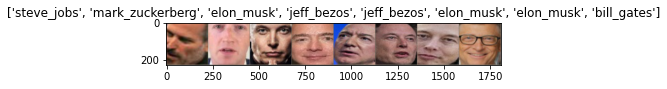

In [7]:
def imshow(inp, title=None):
    """Визуализация доступных данных"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """Настройка алгоритма обучения модели передача в модель соответсвующих параметров"""
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 

            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
               
                optimizer.zero_grad()
             
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
  
    model.load_state_dict(best_model_wts)
    return model

In [9]:
def visualize_model(model, num_images=8):
    """Визуализация полученной модели"""
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Возьмем предобученную модель (в данном случае resnet50)

In [10]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.6)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# Обучение модели

In [11]:
model_ft = train_model(model_ft, 
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=6)

Epoch 0/5
----------
train Loss: 1.2148 Acc: 0.5060
valid Loss: 0.5425 Acc: 0.8293

Epoch 1/5
----------
train Loss: 0.6760 Acc: 0.7563
valid Loss: 0.1864 Acc: 0.9442

Epoch 2/5
----------
train Loss: 0.4874 Acc: 0.8270
valid Loss: 0.1216 Acc: 0.9628

Epoch 3/5
----------
train Loss: 0.4119 Acc: 0.8583
valid Loss: 0.0823 Acc: 0.9814

Epoch 4/5
----------
train Loss: 0.3523 Acc: 0.8760
valid Loss: 0.0630 Acc: 0.9847

Epoch 5/5
----------
train Loss: 0.3120 Acc: 0.8967
valid Loss: 0.0530 Acc: 0.9902

Training complete in 3m 58s
Best val Acc: 0.990153


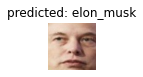

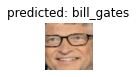

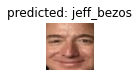

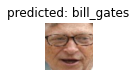

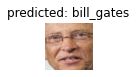

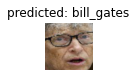

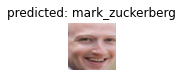

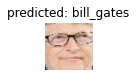

In [12]:
visualize_model(model_ft)

# Построение матрицы ошибок

In [13]:
class_names

['bill_gates', 'elon_musk', 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs']

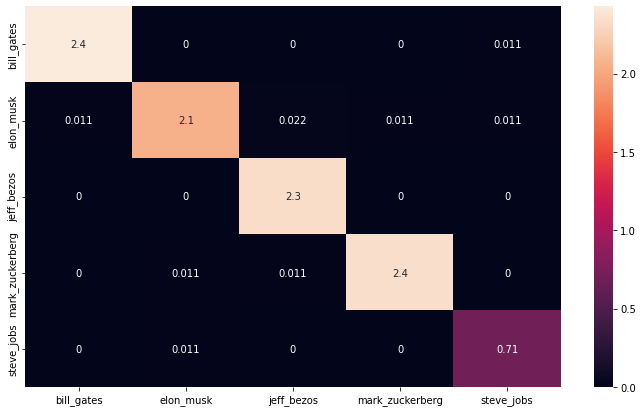

In [14]:
y_pred = []
y_true = []

for inputs, labels in dataloaders['valid']:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        inputs, labels = inputs.to(device), labels.to(device)

        output = model_ft(inputs)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

classes = class_names

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')